## DATA used in CCN2025 paper

In [1]:
import numpy as np
import xarray as xr
from src.EEGModalNet.preprocessing.preprocessing import preprocess_data
from mne.time_frequency import psd_array_welch
from matplotlib import pyplot as plt
from scipy.signal import butter, sosfiltfilt, resample
def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


### Preprocessing

In [ ]:
downsample_frq = 98
sampling_rate = 128
# channels = ['O1', 'Oz', 'O2', 'P1', 'Pz', 'P2', 'C3', 'C1', 'C2', 'C4', 'F1', 'Fz', 'F2', 'AF3', 'AFz', 'AF4']
data_path = 'data/LEMON_data/eeg_eo_ec.nc5'
xarray = xr.open_dataset(data_path, engine='h5netcdf')

subjects = xarray.subject.to_numpy()
x = xarray['eye_closed'].to_numpy()
channels = xarray.channel.to_numpy()

if downsample_frq is not None:
    print(f'>>> downsampling the data to {downsample_frq} Hz')
    n_samples = int((x.shape[-1] / sampling_rate) * downsample_frq)
    x = resample(x, num=n_samples, axis=-1)
    sampling_rate = downsample_frq

print('preprocessing...')
data = preprocess_data(x, sampling_rate=sampling_rate)

# create a dataaraay and save
if downsample_frq is not None:
    data_path_save = 'data/LEMON_data/EC_all_channels_processed_downsampled.nc5'
else:
    data_path_save = 'data/LEMON_data/EC_all_channels_processed.nc5'
xarray = xr.DataArray(data, dims=['subject', 'channel', 'time'])
xarray = xarray.assign_coords(subject=subjects, channel=channels)

In [ ]:
# Assign Attributes to the new xarray
xarray_old = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
channel_ids = find_channel_ids(xarray_old, channels)

xarray = xarray.assign_attrs({'gender':xarray_old.attrs['gender'],
                               'ch_positions':xarray_old.attrs['ch_positions'][channel_ids]},)

# xarray.to_netcdf(data_path_save, engine='h5netcdf')

### Inspect the PSD of the preprocessed data 

In [24]:
# open preprocessed data
data_path = 'data/LEMON_data/EC_8_channels_processed.nc5'
channels = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']
xarray = xr.open_dataarray(data_path, engine='h5netcdf')
x = xarray.to_numpy()

# apply butterworth filter
sos = butter(4, 1, btype='high', fs=128, output='sos')
x_filtered = sosfiltfilt(sos, x, axis=2)

In [41]:
psd, freq = psd_array_welch(x_filtered, sfreq=128, n_fft=256, n_per_seg=256, n_overlap=128, average='mean')

Effective window size : 2.000 (s)


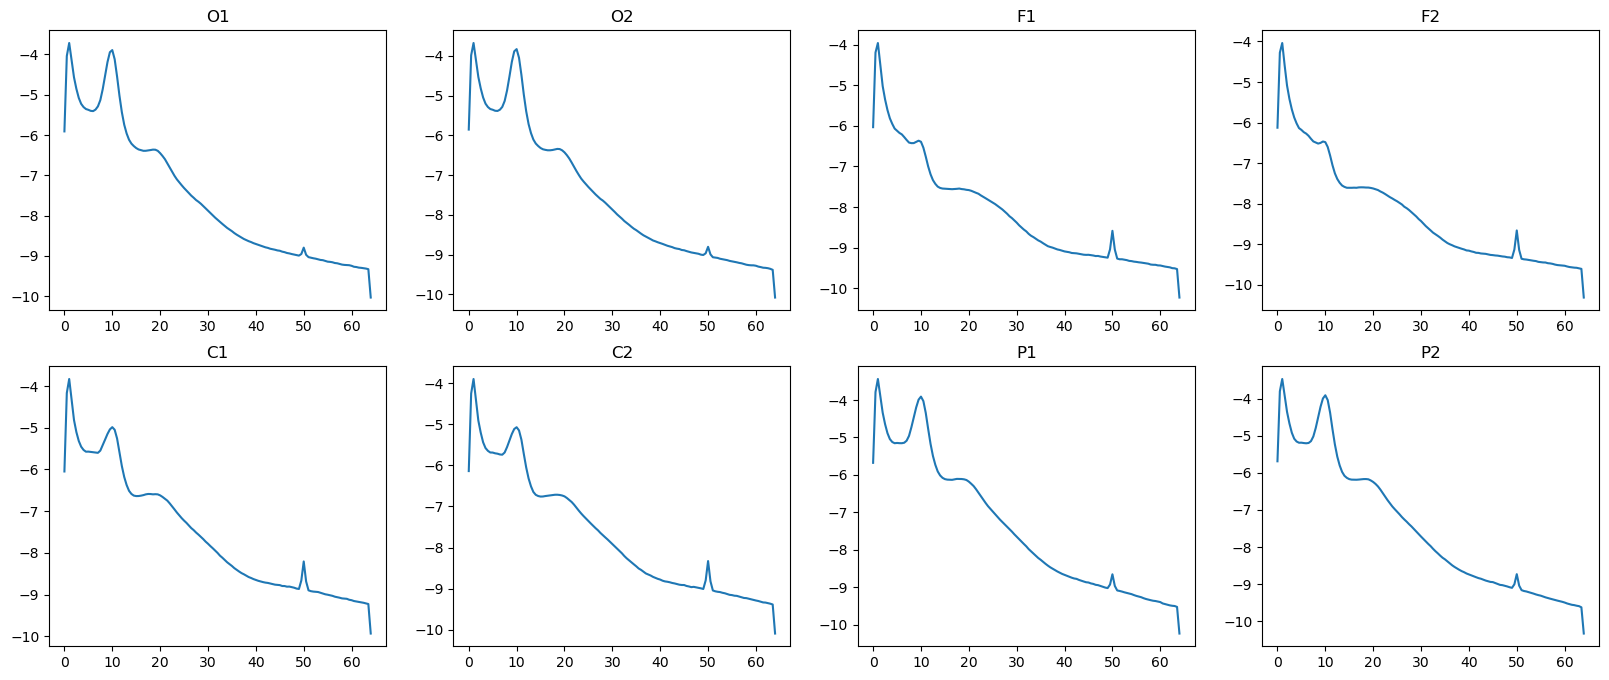

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(x.shape[1]):
    ax = axes[i // 4, i % 4]
    ax.plot(freq, np.log(psd[:, i, :]).mean(axis=0))
    ax.set_title(channels[i])

## the effect of downsampling on PSD

In [29]:
channels = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']
data_path = 'data/LEMON_data/eeg_eo_ec.nc5'
xarray = xr.open_dataset(data_path, engine='h5netcdf')

subjects = xarray.subject.to_numpy()
x = xarray['eye_closed'].sel(channel=channels).to_numpy()

Effective window size : 2.612 (s)


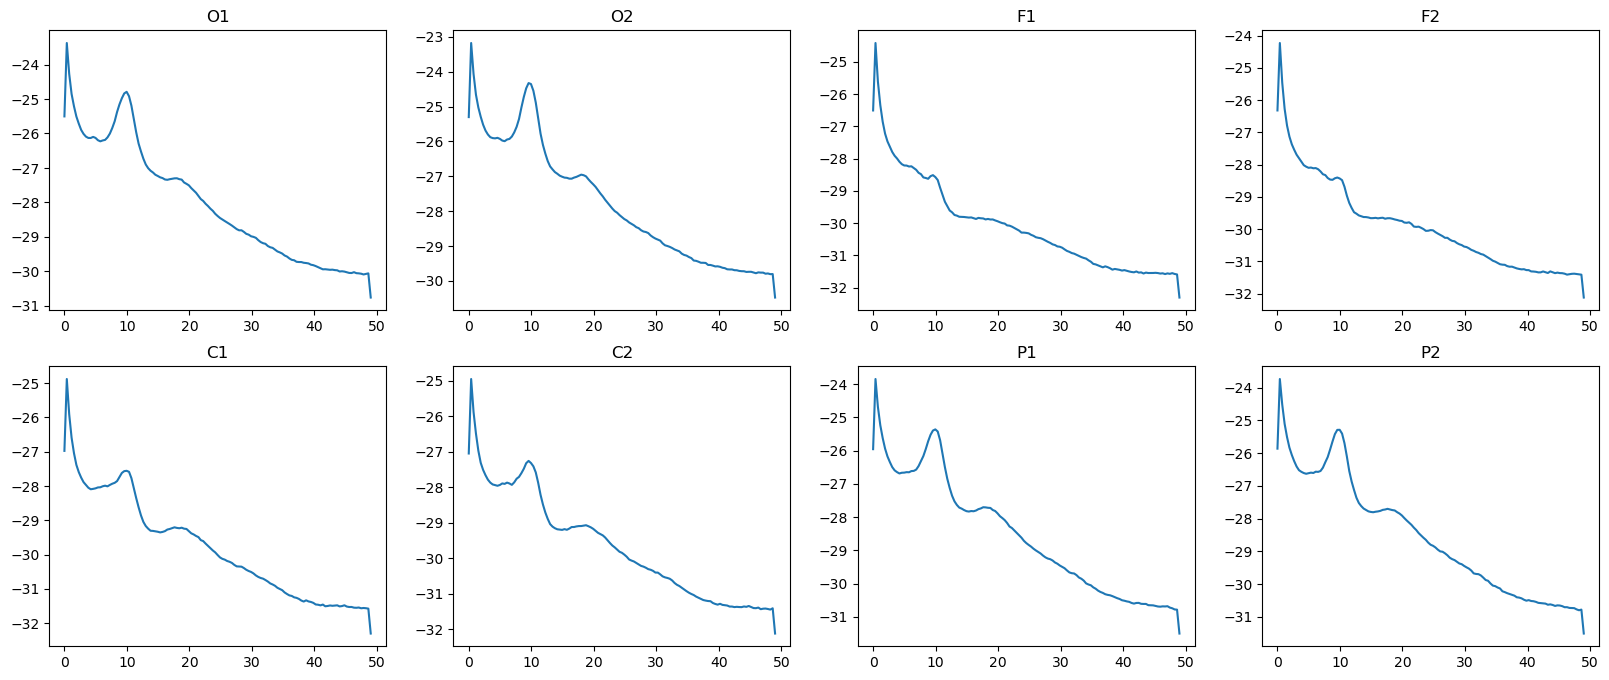

In [33]:
# down sample
from scipy.signal import resample
downsample_frq = 98
n_samples = int((x.shape[-1] / 128) * downsample_frq)
x_resampled = resample(x, num=n_samples, axis=-1)

psd, freq = psd_array_welch(x_resampled, sfreq=downsample_frq, n_fft=256, n_per_seg=256, n_overlap=downsample_frq, average='mean')
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(x.shape[1]):
    ax = axes[i // 4, i % 4]
    ax.plot(freq, np.log(psd[:, i, :]).mean(axis=0))
    ax.set_title(channels[i])

In [ ]:
# running average
x_conv = np.zeros((20, 61438))
for i in range(20):
    x_conv[i, :] = np.convolve(x[i, 2, :], np.ones(3)/3, mode='valid')